In [2]:
import numpy as np
import pandas as pd
import os
import torch

In [20]:
csv_list = os.listdir("train")

df = pd.DataFrame()

for file in csv_list:
    if file.endswith(".csv"):
        df_temp = pd.read_csv(f"train/{file}")
        df = pd.concat([df, df_temp])
        
df

,LocationCode,DateTime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,10,2024-03-01 17:14:06.000,0.0,1017.48,15.59,94.30,652.92,0.12
1,10,2024-03-01 17:14:47.000,0.0,1017.48,15.66,94.04,682.50,0.12
2,10,2024-03-01 17:15:47.000,0.0,1017.47,15.74,94.10,750.00,0.14
3,10,2024-03-01 17:16:47.000,0.0,1017.46,15.78,94.09,738.33,0.14
4,10,2024-03-01 17:17:47.000,0.0,1017.49,15.80,94.08,660.83,0.12
...,...,...,...,...,...,...,...,...
89607,9,2024-07-23 15:50:57.000,0.0,994.54,30.69,72.91,2288.33,1.10
89608,9,2024-07-23 15:51:57.000,0.0,994.40,30.27,73.16,3236.67,1.92
89609,9,2024-07-23 15:52:57.000,0.0,994.39,29.90,72.51,4526.67,3.57
89610,9,2024-07-23 15:53:57.000,0.0,994.40,29.38,73.23,4231.67,3.13


In [21]:
from sklearn.preprocessing import StandardScaler
import category_encoders as ce


# 指定要標準化的欄位
columns_to_standardize = ['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)']

# 初始化 StandardScaler
scaler = StandardScaler()

# 對指定欄位進行標準化
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

df['DateTime'] = pd.to_datetime(df['DateTime'])



In [22]:

def mean_10min(df):
    location = df["LocationCode"].unique()
    new_df = pd.DataFrame()
    
    for l in location:
        l_df = df[df["LocationCode"] == l]
        l_df.set_index('DateTime', inplace=True)
        l_df = l_df.resample('10min').mean().dropna()  # 將 '10T' 改為 '10min'
        l_df = l_df.reset_index()
        l_df["LocationCode"] = l  # 添加 LocationCode 列
        #l_df = l_df.drop(columns=["DateTime", "LocationCode"])  # 如果不需要 DateTime 列的話可以刪除
        
        # 將 l_df 與 new_df 合併
        new_df = pd.concat([new_df, l_df], ignore_index=True)
    
    return new_df

df = mean_10min(df)





,DateTime,LocationCode,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,2024-03-01 17:10:00,10,-0.258691,0.488069,-1.648270,0.982120,-0.714861,0.115714
1,2024-03-01 17:20:00,10,-0.011207,0.485448,-1.648478,0.991789,-0.721686,0.063000
2,2024-03-01 17:30:00,10,-0.352988,0.489499,-1.657738,1.010477,-0.727369,0.022000
3,2024-03-01 17:40:00,10,-0.124700,0.490809,-1.655061,1.034913,-0.731652,0.013000
4,2024-03-01 17:50:00,10,-0.398646,0.496111,-1.653945,1.056414,-0.734889,0.002000
...,...,...,...,...,...,...,...,...
131750,2024-07-23 15:10:00,9,-0.420823,-0.921951,-0.047603,0.210220,-0.597407,3.284000
131751,2024-07-23 15:20:00,9,-0.420823,-0.937738,0.028268,0.119954,-0.463416,12.524000
131752,2024-07-23 15:30:00,9,-0.420823,-0.930291,0.126900,0.017068,-0.405956,18.536000
131753,2024-07-23 15:40:00,9,-0.420823,-0.910632,0.086733,0.038168,-0.595489,4.002000


In [30]:
df["DateTime"]

<bound method Series.min of 0        2024-03-01 17:10:00
1        2024-03-01 17:20:00
2        2024-03-01 17:30:00
3        2024-03-01 17:40:00
4        2024-03-01 17:50:00
                 ...        
131750   2024-07-23 15:10:00
131751   2024-07-23 15:20:00
131752   2024-07-23 15:30:00
131753   2024-07-23 15:40:00
131754   2024-07-23 15:50:00
Name: DateTime, Length: 131755, dtype: datetime64[ns]>

In [31]:
def spilt_data_with_datetime(df: pd.DataFrame):
    op_df = list(df['DateTime'].dt.day)
    
    data_df = df.drop(columns=['DateTime', 'Power(mW)', 'LocationCode'])
    label_df = df['Power(mW)']

    data_list = []
    label_list = []
    last_index = 0
    for i in range(1, len(op_df) - 1):
        if op_df[i] != op_df[i - 1]:
            data_list.append(torch.from_numpy(np.array(data_df.iloc[last_index: i])))
            label_list.append(torch.from_numpy(np.array(label_df.iloc[last_index:i])))
            last_index = i
    return data_list, label_list

In [32]:
data_list, label_list = spilt_data_with_datetime(df)

data_list[0].shape, label_list[0].shape

(torch.Size([6, 5]), torch.Size([6]))

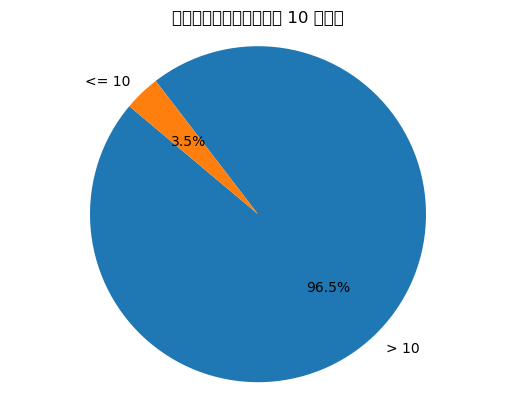

In [37]:
import matplotlib.pyplot as plt
from collections import Counter

# 假設這是你的字串陣列

# 計算每個字串的長度
lengths = [len(s) for s in data_list]

# 設定臨界長度
threshold = 10

# 計算大於和小於等於 threshold 的比例
greater_count = sum(1 for length in lengths if length > threshold)
less_equal_count = sum(1 for length in lengths if length <= threshold)

# 繪製圓餅圖
labels = [f'> {threshold}', f'<= {threshold}']
sizes = [greater_count, less_equal_count]

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 確保圓餅圖是圓形
plt.title(f'序列長度大於和小於等於 {threshold} 的比例')
plt.show()

In [38]:
def slice_seq_to_same_length(datas: list, labels: list, length: int):
    train_data = []
    train_label = []
    test_data = []
    test_label = []

    for i in range(len(datas)):
        data = datas[i]
        label = labels[i]
        start = 0
        end = len(data)
        while end - start >= length:
            train_data.append(data[start:start + length])
            train_label.append(label[start:start + length])
            start += length
        if start != end:
            test_data.append(data[start:start + length])
            test_label.append(label[start:start + length])
    return np.array(train_data), np.array(train_label), np.array(test_data, dtype=object), np.array(test_label, dtype=object)


train_data, train_label, test_data, test_label = slice_seq_to_same_length(data_list, label_list, 10)

for data in train_data:
    assert len(data) == 10

train_data.shape, train_label.shape
    

((12309, 10, 5), (12309, 10))

In [39]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn

In [40]:



# 將數據轉換為 PyTorch 張量
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_label_tensor = torch.tensor(train_label, dtype=torch.float32)

# 建立 TensorDataset
dataset = TensorDataset(train_data_tensor, train_label_tensor)

# 設定訓練和驗證集的比例，例如 80% 給訓練集，20% 給驗證集
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 建立 DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# 檢查形狀
for batch_data, batch_labels in train_loader:
    print(f"Batch data shape: {batch_data.shape}, Batch labels shape: {batch_labels.shape}")
    break

Batch data shape: torch.Size([64, 10, 5]), Batch labels shape: torch.Size([64, 10])


In [41]:
# 將數據轉換為 PyTorch 張量列表，保留每個序列的不同長度
test_data_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_data]
test_label_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_label]

# 建立自定義 Dataset 用於處理不同長度的序列
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 建立 Test Dataset 和 DataLoader
test_dataset = TestDataset(test_data_tensors, test_label_tensors)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 檢查測試資料加載情況
for data, label in test_loader:
    print(f"Data shape: {data[0].shape}, Label shape: {label[0].shape}")
    break

Data shape: torch.Size([6, 5]), Label shape: torch.Size([6])


C:\Users\weiso131\AppData\Local\Temp\ipykernel_23296\2696224944.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_data]
C:\Users\weiso131\AppData\Local\Temp\ipykernel_23296\2696224944.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_label_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_label]


In [42]:
class LSTMTagger(nn.Module):

    def __init__(self, hidden_dim, tagset_size, input_dim=5):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM層，輸入維度為 input_dim，輸出維度為 hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # 線性層將 LSTM 的輸出映射到標籤空間
        self.linear = nn.Linear(hidden_dim, tagset_size)
        self.relu = nn.ReLU()

    def init_hidden(self, batch_size):
        # 初始化隱藏狀態和細胞狀態
        return (torch.zeros(1, batch_size, self.hidden_dim),
                torch.zeros(1, batch_size, self.hidden_dim))

    def forward(self, sentence, hidden):
        # sentence 的形狀為 (batch_size, seq_len, input_dim)
        # LSTM 層的輸出 lstm_out 形狀為 (batch_size, seq_len, hidden_dim)
        # 並傳回更新後的隱藏狀態
        lstm_out, hidden = self.lstm(sentence, hidden)

        # 使用線性層將 LSTM 的輸出映射到標籤空間
        tag_space = self.relu(self.linear(self.relu(lstm_out)))

        # tag_space 的形狀為 (batch_size, seq_len, tagset_size)
        return tag_space, hidden

In [43]:
import torch
import torch.optim as optim
import torch.nn as nn

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定義訓練函數
def train_model(model, train_loader, valid_loader, num_epochs=10, learning_rate=0.001):
    # 將模型移到 GPU
    model = model.to(device, dtype=torch.float32)
    # 使用 Adam 優化器
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 定義損失函數
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for inputs, labels in train_loader:
            # 將輸入和標籤移到 GPU
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 清零梯度
            optimizer.zero_grad()
            # 前向傳播
            outputs, _ = model(inputs, hidden)
            # 計算損失
            loss = criterion(outputs.squeeze(), labels)
            # 反向傳播
            loss.backward()
            # 更新參數
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss / len(train_loader):.4f}")

        # 驗證模型
        valid_loss = validate_model(model, valid_loader, criterion)

# 定義驗證函數
def validate_model(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    error = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # 將輸入和標籤移到 GPU
            inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            
            # 初始化隱藏狀態
            hidden = model.init_hidden(batch_size=inputs.size(0))
            hidden = tuple([h.to(device, dtype=torch.float32) for h in hidden])

            # 前向傳播
            outputs, _ = model(inputs, hidden)
            # 計算損失
            
            loss = criterion(outputs.squeeze(), labels.squeeze())
            error += abs(outputs.view(-1) - labels.view(-1)).sum()
            total_loss += loss.item()

    print(f"Validation Loss: {total_loss / len(valid_loader):.4f}, valid error: {error}")
    return total_loss


In [45]:
model = LSTMTagger(128, 1)
train_model(model, train_loader, valid_loader, 500)


Epoch [1/500], Training Loss: 289670.6473
Validation Loss: 265173.3930, valid error: 3031027.5
Epoch [2/500], Training Loss: 283085.4731
Validation Loss: 259450.5812, valid error: 2993466.25
Epoch [3/500], Training Loss: 279358.2503
Validation Loss: 254442.6344, valid error: 2955005.0
Epoch [4/500], Training Loss: 273200.7688
Validation Loss: 248736.6879, valid error: 2886556.5
Epoch [5/500], Training Loss: 263501.8761
Validation Loss: 239145.4312, valid error: 2786944.5
Epoch [6/500], Training Loss: 254290.3477
Validation Loss: 230153.5730, valid error: 2703066.0
Epoch [7/500], Training Loss: 244555.1351
Validation Loss: 222137.1229, valid error: 2632154.5
Epoch [8/500], Training Loss: 236996.2848
Validation Loss: 214994.6480, valid error: 2565808.0
Epoch [9/500], Training Loss: 230101.2580
Validation Loss: 208378.4840, valid error: 2501045.5
Epoch [10/500], Training Loss: 223619.4706
Validation Loss: 201972.9463, valid error: 2464357.5
Epoch [11/500], Training Loss: 215355.5363
Valid

KeyboardInterrupt: 

In [46]:
criterion = nn.MSELoss()
validate_model(model, test_loader, criterion)
print()

Validation Loss: 3990.8903, valid error: 92054.828125



In [47]:
data_num = 0
for i in range(len(test_data)):
    data_num += len(test_data[i])
data_num

8600

In [70]:
model = model.to(device='cpu')
test_data_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_data]

for i in range(len(test_data_tensors)):

    x = test_data_tensors[i].unsqueeze(dim=0)
    y = test_label_tensors[i]
    hidden = model.init_hidden(batch_size=x.size(0))
    predict, _ = model(x, hidden)
    print(predict[0])
    print(y)


C:\Users\weiso131\AppData\Local\Temp\ipykernel_23296\3131835517.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in test_data]


tensor([[8.4197],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<SelectBackward0>)
tensor([0.1157, 0.0630, 0.0220, 0.0130, 0.0020, 0.0000])
tensor([[8.6690],
        [0.0000],
        [0.0000]], grad_fn=<SelectBackward0>)
tensor([0.0120, 0.0010, 0.0000])
tensor([[5.2400],
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<SelectBackward0>)
tensor([0.1090, 0.0310, 0.0080, 0.0000])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SelectBackward0>)
tensor([0.2450, 0.0780, 0.0240, 0.0050, 0.0000])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SelectBackward0>)
tensor([0.5010, 0.1060, 0.0200, 0.0040, 0.0100])
tensor([[5.2886],
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<SelectBackward0>)
tensor([0.0250, 0.0100, 0.0020, 0.0000])
tensor([[8.6352],
        [0.0000],
        [0.0000],
        [0.0000],
        [1.6306],
        [1.1111],
        